<a href="https://colab.research.google.com/github/kesana-mohana-mounika/Intern_orbit_internship_task_3/blob/main/Terrorism_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix


In [37]:
df=pd.read_csv("/content/drive/MyDrive/globalterrorismdb_0718dist.csv",encoding="latin1",low_memory=False)

In [38]:
# 2. Select useful columns
cols = ['iyear','imonth','iday','country_txt','region_txt','attacktype1_txt',
        'targtype1_txt','weaptype1_txt','latitude','longitude','nkill','nwound','gname']
df = df[cols]

In [39]:
# 3. Feature Engineering
df['casualties'] = df[['nkill','nwound']].fillna(0).sum(axis=1)
df = df.dropna(subset=['latitude','longitude','attacktype1_txt'])


In [40]:

# 4. Encode categorical features using LabelEncoders and store them
categorical_cols = ['country_txt','region_txt','attacktype1_txt','targtype1_txt','weaptype1_txt','gname']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Save encoders for later use

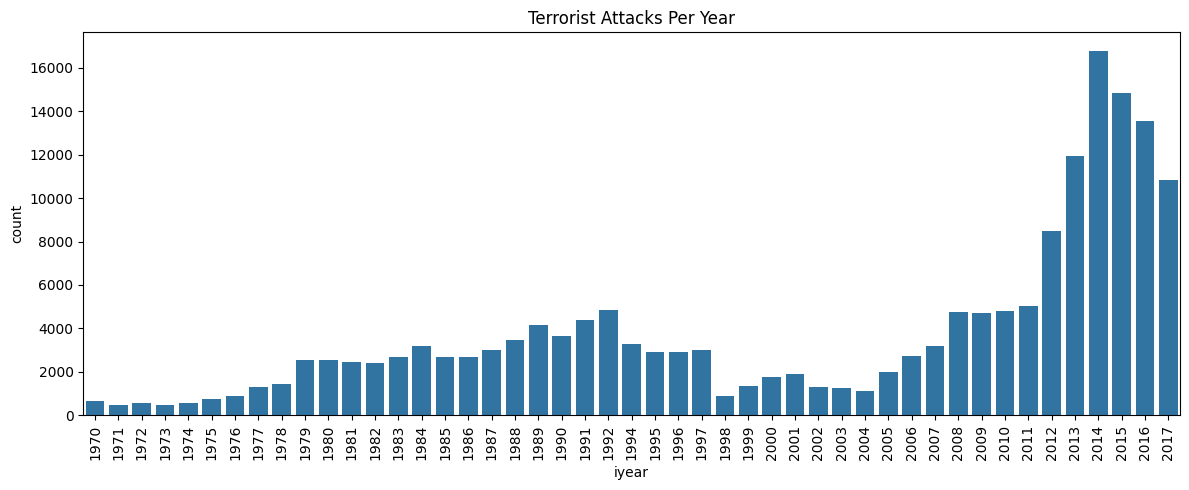

In [41]:
# 5. EDA: Visualizations
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='iyear')
plt.xticks(rotation=90)
plt.title("Terrorist Attacks Per Year")
plt.tight_layout()
plt.show()

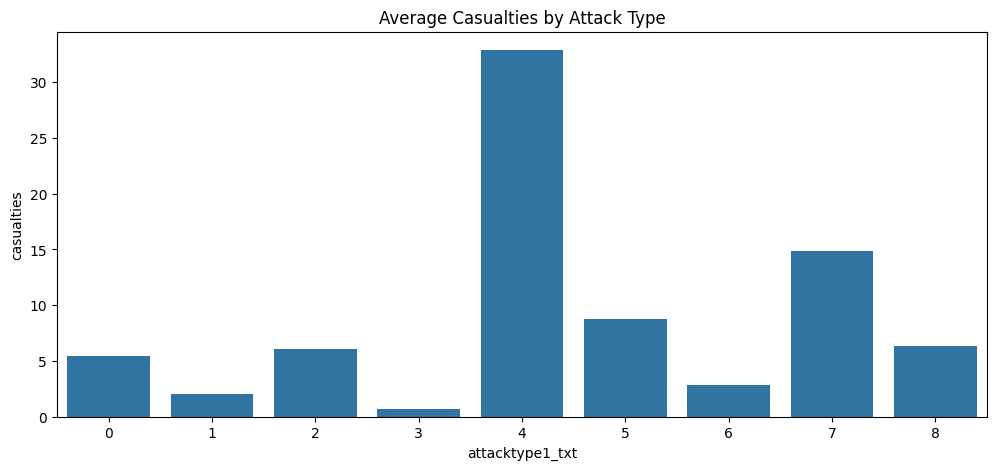

In [42]:
plt.figure(figsize=(12,5))
avg_casualties = df.groupby('attacktype1_txt')['casualties'].mean().reset_index()
sns.barplot(x='attacktype1_txt', y='casualties', data=avg_casualties)
plt.title("Average Casualties by Attack Type")
plt.show()

In [43]:

# 6. Clustering with DBSCAN
coords = df[['latitude','longitude']]
db = DBSCAN(eps=1.0, min_samples=10).fit(coords)
df['cluster'] = db.labels_


In [44]:
# 7. ML Modeling
features = ['imonth','iday','country_txt','region_txt','latitude','longitude','casualties']
target = 'attacktype1_txt'

X = df[features].fillna(0)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\n🔍 Model Evaluation:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



🔍 Model Evaluation:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      8222
           1       0.51      0.43      0.47      3764
           2       0.68      0.80      0.74     17369
           3       0.56      0.42      0.48      2037
           4       0.15      0.06      0.09       126
           5       0.32      0.13      0.18       192
           6       0.42      0.25      0.31      2134
           7       0.50      0.18      0.27       197
           8       0.41      0.16      0.23      1386

    accuracy                           0.61     35427
   macro avg       0.45      0.33      0.37     35427
weighted avg       0.59      0.61      0.59     35427

Confusion Matrix:
[[ 4280   694  2805   128     8    12   199    10    86]
 [  938  1620  1061    30     3     6    75     3    28]
 [ 1947   593 13952   385    19    20   299     5   149]
 [  182    41   842   862     4     4    76     7    19]
 [   18     9    64     5   

In [45]:
# 8. Future Prediction Test Case (Safe from unseen label error)

# Define values
future_country = 'India'
future_region = 'South Asia'

# Handle unseen labels (if country or region not in encoder, skip prediction)
if (future_country not in label_encoders['country_txt'].classes_ or
    future_region not in label_encoders['region_txt'].classes_):
    print(f"\n❌ '{future_country}' or '{future_region}' not in training data. Retrain with full data.")
else:
    # Encode using saved encoders
    encoded_country = label_encoders['country_txt'].transform([future_country])[0]
    encoded_region = label_encoders['region_txt'].transform([future_region])[0]

    # Future input scenario
    future_df = pd.DataFrame([{
        'imonth': 7,
        'iday': 19,
        'country_txt': encoded_country,
        'region_txt': encoded_region,
        'latitude': 28.6139,
        'longitude': 77.2090,
        'casualties': 10
    }])

    future_scaled = scaler.transform(future_df)
    prediction_code = clf.predict(future_scaled)[0]
    prediction_label = label_encoders['attacktype1_txt'].inverse_transform([prediction_code])[0]

    print(f"\n✅ Future Prediction for 19 July in {future_country}:")
    print(f"Predicted Attack Type: {prediction_label}")


✅ Future Prediction for 19 July in India:
Predicted Attack Type: Bombing/Explosion
